# Image-based Food Classification with Deep Neural Networks

<hr>

## 1 Introduction

Image classification is the task of assigning an input image one label from a fixed set of categories. It is one of the core problems in Computer Vision that, despite its simplicity, has a large variety of practical applications ranging from Web search engines to multimedia information delivery. 

In the past, several approaches have been proposed for image classification. These approaches mainly rely on traditional machine learning methods where a machine learning classifier (e.g., SVM, MaxEnt, J48) is trained from features extracted from labelled images. 

However, in recent years, deep learning has emerged as a promising machine learning technique able to capture high level abstractions in the data, providing significant improvement for the image classification task over more traditional machine learning methods.  This is mainly due to the capacity of deep learning models to capture multiple layers of information from large amount of data, producing therefore much more efficient semantic feature representations of the image that helps improving image classification performance

In this assignment, we propose a deep learning model for image-based food classification, e.g., determining whether a picture is that of a Sandwich or Sushi. Our models, as will be subsequently explained, is built on top of a convolutional neural network (CNN) that we use for training and evaluating the model. 

We experiment with our model on two food datasets: 
* The Cookpad dataset, which consists of 804 food images labelled as either “Sandwich” or “Sushi”. 
* A subset of Food_101 dataset which contains 1,894 Sandwich and Sushi images

Our results show that our model produce 61.5% in accuracy and 61.5% in average F1-measure when merely trained from Cookpad dataset. However, retraining the proposed model on the Food_101 dataset shows to improve the performance significantly, achieving 80.2% in accuracy and F1-measure. 

The reminder of this interactive notebook is organised as follows. In Section 2, we describe the technical requirements for building, training and testing our model. Section 3 describes our proposed deep learning model for image classification. Section 4 shows our evaluation setup and the results of our experiments. Section 5 describes how we retrain our model on the Food_101 dataset. Section 6 discusses the deployment of the model as a mobile application, and Section 8 concludes this work.


<a id='section_2'></a>
<hr>

## 2 Technical Requirements

As mentioned before, this assigment consists of building and training a CNN model for image-based food classification. To achieve this we use several deep learning, machine learning and text processing python libraries and toolkits, as listed and described below. Note that we use Python 2.7 in all our code in this assigment.


<b>Tensorflow</b> <i>(Version 1.2.0+)</i>

<a href='https://www.tensorflow.org/'>Tensorflow</a> is an open source software library released in 2015 by Google to make it easier for developers to design, build, and train deep learning models. Tensorflow allows users to express arbitrary computation as a graph of data flows. Nodes in this graph represent mathematical operations, whereas edges represent data that is communicated from one node to another. The beauty of this library comes from its capacity and flexibility for writing and building deep learning applications for embedded/mobile devices to scalable clusters in the cloud while taking care (under the hood) of the GPU matrix operations and low level mathematical operations such as partial derivative gradients or stochastic optimizers.

<b>TFLearn</b> <i>(Version 0.3.2+)</i>

<a href='http://tflearn.org/'>TFLearn</a> is a deep learning library build on top of Tensorflow and designed to provide a higher-level API to TensorFlow. In this assignment we will use TFLearn to design, train and test our CNN model.  

<b>Scikit-learn</b> <i>(Version 0.18.1+)</i>

<a href='http://scikit-learn.org/'>scikit-learn</a> is a machine learning library intially developed by David Cournapeau as a Google summer of code project in 2007. Scikit-learn provides a range of supervised and unsupervised learning algorithms via a consistent interface in Python. The library is built upon the <a href='https://www.scipy.org/'>SciPy</a> (Scientific Python) that must be installed before we can use scikit-learn. 

We mainly use Scikit-learn in this assignment for data preparation and model evaluation 

In addition to the above libraries, we also use <i>NumPy</i> (http://www.numpy.org/) to deal with arrays and scientific computing, <i>Matplotlib</i> (https://matplotlib.org/) for 2d plotting, and <i>Tabulate</i> (https://pypi.python.org/pypi/tabulate) to Pretty-print tabular data. 

## Installation

Code and data we use in this project is avaible on github: https://github.com/Staano/image_food_classification.git
A Docker image that contains all the depencies required to run this project is avaible on Dockerhub: https://hub.docker.com/r/hsaif/jupyter-deeplearning/

- Download or clone the project from github to a local directory
- Pull the Docker image by simply excuting the Dockerfile in the project directory or simply by running the follwoing command: 
<pre> docker pull hsaif/jupyter-deeplearning </pre>

- Once you the image is downloaded we can run it as:
<pre> docker run -d -p 8888:8888 -v /PROJECT_DIRECTRORY:/home/ds/notebooks hsaif/jupyter-deeplearning </pre>

    Please change PROJECT_DIRECTRORY to the directory where you stored the project in
    
- Access Jupyter server on: http://localhost:8888/ where you can browse and run this notebook
- You may be required to enter access token to access Jupyter notebook. To obtained the access token, run the following commands:
<pre> sudo docker exec -i -t container_id /bin/bash # access container shell</pre>
<pre> jupyter notebook list # obtained the access token</pre>

    Set container_id to the hsaif/jupyter-deeplearning container id

<hr><hr>


Let's start running the code by importing first all the liberires required to build our model

In [1]:
# Libraries we are going to use:
import numpy as np               # dealing with arrays
import matplotlib.pyplot as plt  # dealing with plots 
# import plotly.plotly as py       # dealing with plots as well
import os                        # dealing with directories
from random import shuffle       # shuffle data.
from tqdm import tqdm            # make loops show a smart and nice progress meter (Fnacy stuff, nothing serious!)
import math
from PIL import Image
from tabulate import tabulate
%matplotlib inline

from IPython.display import display, Image

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.data_utils import image_preloader
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

from sklearn.metrics import (classification_report, accuracy_score, 
                             precision_score, recall_score, f1_score, 
                             confusion_matrix, precision_recall_fscore_support)
from sklearn.model_selection import train_test_split

Little code to disable auto autoscrolling of long output

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<hr>
## 3 A Deep Learning Model Model for Image Classification

In this section, we introduce our deep learning model for image classification of food data. As already mentioned, for the purpose of this assignment we choose to use Convolutional Neural Networks (CNN) to build and train our model. This is because CNNs have shown a great success and capacity in learning good internal representations of images and features from large training datasets [1,3]. Such capacity can be controlled by varying their depth and breadth, and they also make strong and mostly correct assumptions about the nature of images. Hence, compared to standard feedforward neural networks with similarly-sized layers, CNNs have much fewer connections and parameters and so they are easier to train, while their theoretically-best performance is likely to be only slightly worse. <i>(Section 3.2 describes the architecture of our model)</i>


Similar to supervised machine learning approches, CNN takes as input a set of labelled images during the training phase to learn their feature representation. Once trained, the CNN model can be applied to unlabelled images to predict their class/category. 

As such, the pipeline of our image classification approach breaks down into three main phases as dipected in Figure 1: 

<img src="figures/pipeline.jpg">

* <b>Data Prepration and Preprocessing:</b> This phase takes as input a set of images from a given dataset and applies a seriese of preprocessing routines on them, such as resizing, normalisation and augmentation.
* <b>Model Training and Validation:</b> This phase consists on constructing and training the CNN model from the image training set 
* <b>Model Evaluation</b> This phase applies the trained model on a set of test images to measure its performance
* <b>Model Deployment</b> In this phase we discuss how the proposed model can be deployed as a mobile app. Note that due the time constraints we will leave code implementation for this phase for future work. 

In the following subsections we show how to perform each of the phases in more details. 


### 3.1 Data Preparation and Preprocessing

In this assignment We use two datasets for training and testing our model in this assigment: the Cookpad dataset and the Food_101 dataset. 

We start first by loading, processing and using the Cookpad image set for the initial training and testing of our model. The dataset can be obtained from: (http://research.us-east-1.s3.amazonaws.com/public/sushi_or_sandwich_photos.zip)

This dataset folder contains two directories: (i) "sandwich", which contains 402 sandwish images and (ii) "sushi" which contains 402 sushi images.

In [3]:
# Let's define some constants

SANDWICH_IMG_DIR = 'datasets/cookpad_dataset/sandwich'
SUSHI_IMG_DIR = 'datasets/cookpad_dataset/sushi'
            
TRAIN_DATA_FILE = 'datasets/cookpad_dataset/training.csv'
TEST_DATA_FILE = 'datasets/cookpad_dataset/test.csv'
VALIDATION_DATA_FILE = 'datasets/cookpad_dataset/valid.csv'

TRAIN_PROPORTION=0.6    # Proportion of the data to be used for training
TEST_PROPORTION=0.2     # Proportion of the data to be used for testing
VALID_PROPORTION=0.2    # Proportion of the data to be used for model validation

IMG_SIZE = 96           # Image size used for model training and validation
CHANNELS = 3            # We consdier 3 colour channels (RGB) for our images
LEARNING_RATE = 1e-4    # NN Learning Rate of our 
EPOCHS = 25             # No. of training epobchs

### 3.1.1 Load the Cookpad dataset and spilit it into: Training, Test and Validation subsets

To train and test our model we will to split the cookpad dataset into 3 subsets as follows: 
* Training set (60%): to be used for model training
* Test set (20%): to be used for testing the model
* Validation (20%): to be used for validating the model druing the training phase

As mentioned bofore the Cookpad data consists of an equal number of images under both, the Sandwich (402 images) and Sushi (402 images) classes. It's very important, for efficient and unbiased training of our model, to keep a balanced class distributions of the images in the three subsets during the sampling process. To this end, we will use <a href="http://research-methodology.net/sampling-in-primary-data-collection/stratified-sampling/">Startified Sampling</a> instead of the simple random sampling. To this end, we use <i>train_test_split()</i> function provided by Scikit-learn (Check <i>stratified_split_train_test_valid()<i> function in the code block below)

Below are some helper functions to load and sample the dataset

In [1]:
# Helper function to one hot-encode the image label
def get_image_label(data_path):
    if data_path.split("/")[-1] == 'sandwich':
        return 0
    return 1

# Helper function to load images information (image_path, image_label)
def load_data_info(data_path):
    dataset = []
    for img in tqdm(os.listdir(data_path)):
        if '.jpg' not in img:
            continue
        label = get_image_label(data_path)
        path = os.path.join(data_path, img)
        dataset.append([path, label])
        
        shuffle(dataset)
        
    return dataset

# Helper function to split the dataset into training, test and validation subsets in stratified manner
def stratified_split_train_test_valid(dataset, test_proporation, valid_proporation):
    X = [row[0] for row in dataset]
    y = [row[1] for row in dataset]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_proporation, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valid_proporation, stratify=y_train)
    
    return zip(X_train, y_train), zip(X_test, y_test), zip(X_val, y_val)

# Helper function to show precentages and real numbers insides the pie plot
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

# Helper function to plot the size of the data subsets
def plot_piechart(stats, title):    
    labels = stats.keys()
    sizes = stats.values()
    
    explode = (0, 0.1, 0)

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct=make_autopct(sizes),
            shadow=True, startangle=90)
    
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    plt.title(title)
    plt.legend(labels, loc='center left')  
    plt.show()

Let's now load and sample the dataset

In [5]:
# Load [path, label] of the Cookpad Sandwish and Sushi images
sandwich_data = load_data_info(SANDWICH_IMG_DIR)
sushi_data = load_data_info(SUSHI_IMG_DIR)

# Merge both datasets into one full data
full_dataset = sandwich_data + sushi_data

# Now let's spilit the dataset into: Training, Test and Validation subsets
# Startified sampling is used here to keep a balanced class distribution across the three subsets
training_data, test_data, valid_data = stratified_split_train_test_valid(full_dataset, TEST_PROPORTION, VALID_PROPORTION)

# Save the the URL and Label of images in the three subsets
# Will use these files to load the images into the memory
np.savetxt(fname=TRAIN_DATA_FILE, X=training_data, delimiter=' ', fmt='%s')
np.savetxt(fname=TEST_DATA_FILE, X=test_data, delimiter=' ', fmt='%s')
np.savetxt(fname=VALIDATION_DATA_FILE, X=valid_data, delimiter=' ', fmt='%s')

100%|██████████| 402/402 [00:00<00:00, 15810.64it/s]


The next step is to load the images in the three image subsets. To this end, we will use <i>TFlearn Preloader</i> classes, which enable to handle large datasets, since one may be limited by memory (RAM) and it may not be possible to load the whole dataset at once. Thats when you want to use those classes and only load a part of the data on the fly. For example during the training phase only the batches will be loaded into the RAM when using a Preloader class.

In [6]:
# Load the images and their labels into the memroy
training_x, training_y = image_preloader(TRAIN_DATA_FILE, image_shape=(IMG_SIZE,IMG_SIZE), 
                                        categorical_labels=True,normalize=True)
test_x, test_y = image_preloader(TEST_DATA_FILE, image_shape=(IMG_SIZE,IMG_SIZE), 
                                        categorical_labels=True,normalize=True)
valid_x, valid_y = image_preloader(VALIDATION_DATA_FILE, image_shape=(IMG_SIZE,IMG_SIZE), 
                                        categorical_labels=True,normalize=True)

Let's now show some stats and few examples of images in the Cookpad dataset

Dataset
Number of training images 514
Number of testing images 161
Number of validation images 129
Shape of an image (96, 96, 3)
Shape of label:(2,) ,number of classes: 2


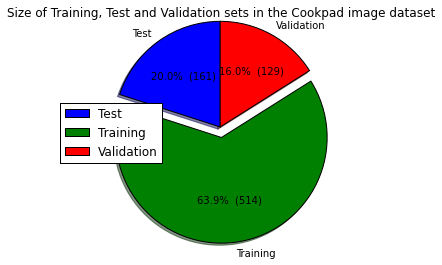

In [7]:
# Print some stats!
print "Dataset"
print "Number of training images {}".format(len(training_x))
print "Number of testing images {}".format(len(test_x))
print "Number of validation images {}".format(len(valid_x))
print "Shape of an image {}" .format(training_x[1].shape)
print "Shape of label:{} ,number of classes: {}".format(training_y[1].shape,len(training_y[1]))

# Plot the distribution of images across the three subsets
stats_cookpad = {'Training':len(training_x), 'Test':len(test_x), 'Validation':len(valid_x)}
plot_piechart(stats_cookpad, "Size of Training, Test and Validation sets in the Cookpad image dataset")

<hr>
Quickly show some samples from the training data just to make sure everything is ok so far!

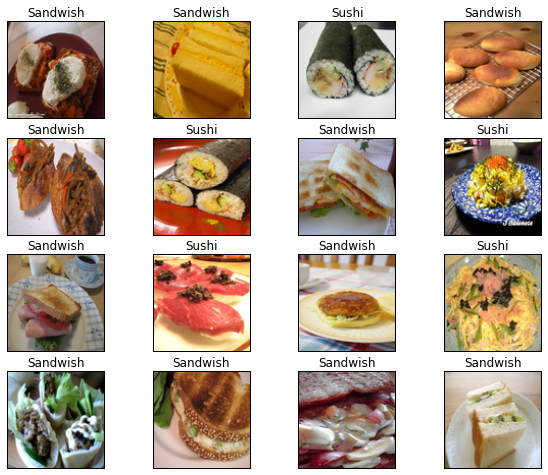

In [8]:
#Plot samples in the training dataset
fig=plt.figure(figsize=(10, 8))

for i in range(0, len(training_x[:16])):
    img = training_x[i]
    label = training_y[i]
    
    # sandwich: [1,0]
    # suhi: [0,1]
    if np.argmax(label) == 0: str_label='Sandwish'
    else: str_label='Sushi'

    y = fig.add_subplot(4,4,i+1)
    
    y.imshow(img,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

<hr>
### 3.1.2 Data Augmentation

Deep networks need to be trained on a huge number of training images to achieve satisfactory performance. In our case however, the Cookpad image dataset contains a small number of images (#804 images only). 

Hence, to solve this issue we resort to perform <i>Data Augmentation</i> to increase the size of our dataset and consequently imporve the classification performance and avoid overfitting. In a nutshell, with small datasets, Data Augmentation becomes the thing must to do when training a deep network. 

Data Augmentation works by creating extra synthetic training data by applying multiple transformations, such as flipping, rotating and blurring images on our data set.

Luckily, TFlearn provides a nice a simple functions to perform realtime data augmentation as shown below.

In [9]:
## Data Augmentation:
# Create extra synthetic training data by flipping, rotating and blurring the
# images on our data set.
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()         # Randomly flip an image (left to right).
img_aug.add_random_rotation(max_angle=25.)  # Randomly rotate an image by a random angle
img_aug.add_random_blur(sigma_max=3.)       # Randomly blur an image by applying a gaussian filter with a random sigma

### 3.1.3 Data Normalization

Now we have extended our orginal image set with the augmented synthetic images, we move to zero-center the data, and then normalize them, which is presented as two lines Python codes as follows:

~~~python
X -= np.mean(X, axis = 0) # zero-center
X /= np.std(X, axis = 0) # normalize
~~~

where X here is the input data. 
The goal here is to is to squash the range of values for all the pixels in the three colour channels of our images to a very small range, which may help our model to run faster and better!

In [10]:
# Let's now make sure the data is normalized:
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center() #Zero center every image with a mean evaluated over all samples.
img_prep.add_featurewise_stdnorm() # Scale each images by a standard deviation evaluated over all samples data.

<hr>
### 3.2 Model Architecture and Training

The next phase in our approach consists of building and training our deep neural network on the Cookpad image dataset processed and loaded in the previous phase. As mentioned before, we choose to use convlutional neural network as our image classifier. Below we give a small technical background about CNNs and how they work, before describing the architecture of our model.

#### CNN - Background

CNN is a variation of multilayer perceptrons and is based on a mathematical operation, called <a href='https://en.wikipedia.org/wiki/Convolution'>convolution</a>, which is, in the context of image classification, a layer of multiple filters that can be applied on a given image to help find its most discriminative features, as shown in Figure 2. 


<img src="figures/Convolution_schematic.gif" >
<b>Fig 2.</b> Convolution with 3×3 Filter. Source: http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution


As such, CNNs consists of just several layers of convolutions with nonlinear activation functions like ReLU or tanh applied to the results. Unlike traditional feedforward neural network, where each input neuron is connected to each output neuron in the next layer (aka Fully Connected Layer), in CNNs we use convolutions over the input layer to compute the output. This results in local connections, where each region of the input is connected to a neuron in the output. 

Now each layer applies different filters (typically hundreds or thousands) and combines their results. During the training phase, a CNN automatically learns the values of its filters based on the task we want to perform. For example, in our image classification task a CNN may learn to detect edges from raw pixels in the first layer, then use the edges to detect simple shapes in the second layer, and then use these shapes to deter higher-level features, such as facial shapes in higher layers. The last layer is then a classifier that uses these high-level features.

Right, enough techicals details for now. However, we refer the reader to (http://cs231n.github.io/convolutional-networks/) for more information about the CNN architectures and operations. 

#### Model Architecture

In this assigment we propose a modified (simplified) version of Google's AlexNet Architecture (Krizhevsky et al. 2012). As shown in the Figure 3. 

As Dipected in Figure 3, the input of our model is a 96x96x3 image followed by 4 convolutional layers with number of filters 32, 64, 128 and 128 for each layer respectively and size filter of 5. These are followed by two fully-connected layers of 1024 neurons. Output layer is of size 2 neruons because our dataset has two classes (Sandwich, Sushi). Note that Max pooling of 2x2 is applied to the output of each convolutional layer. 

<img src="figures/cnn_arch_1.jpg">

It is worth noting choose the optimal CNN architecture and hyper-parameters is typically a very hard task, which includes a lot of experimenting and learning by error. In our case, we tried different several models with different number of layers and filters. The model we chose here is the one that gave a relatively better performance than the other models we experimented with. In Section 7 we further discuss this issue in more detail.

#### A note on Dropout Optimal Value

Dropout is an algorithm for training neural networks that was first presented by at NIPS 2012 [2]
The main objective behind the algorithm is to prevent the co-adaptation of feature detectors, or overfitting, by forcing neurons to be robust and rely on population behavior, rather than on the activity of other specific units.

Although there is not single optimal dropout value, Baldi and Sadowski [2] found that a dropout of 0.5 maximizes the regularization effect. However, in my opinion, it does not necessarily lead to optimal training of deep models. This is becuase dropout value often varies across the network architecture.

For the purpose of this assignment, we empirically set the dropout value to $0.7$ and We will leave discussion and investigation on this issue for another future opportunity

In the code below we define our model arachitecture. We use TFLearn to this end. 

In [11]:
# import tensorflow as tf
# tf.reset_default_graph()

# Input is a IMG_SIZE X IMG_SIZE image with 3 color channels (red, green and blue)
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, CHANNELS], data_preprocessing=img_prep,
                     data_augmentation=img_aug, name='input')

# Convolution#1
convnet = conv_2d(convnet, 32, 5, activation='relu')
# Max pooling
convnet = max_pool_2d(convnet, 5)

# Convolution#2
convnet = conv_2d(convnet, 64, 5, activation='relu')
# Max pooling
convnet = max_pool_2d(convnet, 5)

# Convolution#3
convnet = conv_2d(convnet, 128, 5, activation='relu')
# Max pooling
convnet = max_pool_2d(convnet, 5)

# Convolution#4
convnet = conv_2d(convnet, 128, 5, activation='relu')
# Max pooling
convnet = max_pool_2d(convnet, 5)

# Fully-connected 1024 node neural network
convnet = fully_connected(convnet, 1024, activation='relu')

# Dropout - throw away some data randomly during training to prevent over-fitting
convnet = dropout(convnet, 0.7)

# Fully-connected neural network with two outputs to make the final prediction
convnet = fully_connected(convnet, 2, activation='softmax')

# Tell tflearn how we want to train the network
convnet = regression(convnet, optimizer='adam', learning_rate=LEARNING_RATE, 
                     loss='categorical_crossentropy', name='targets')

# Assign log directory path in order to use Tensorboard
model = tflearn.DNN(convnet, tensorboard_dir='/tmp/log')

Now, it wont always be the case that you're training the network fresh every time. Maybe first you just want to see how 3 epochs trains, but then, after 3, maybe you're done, or maybe you want to see about 5 epochs. We want to be saving our model after every session, and reloading it if we have a saved version, so I will add this:

## Model Training
The training and validation data are both labeled datasets. The training dataset is what we'll fit the neural network with, and the validation dataset is what we're going to use to validate the results. The test data will be "out of sample", meaning that the testing data will only be used to test the accuracy of the network, not to train it. 

Below we show how train the model with 25 epochs and 500 snapshot step. Snapshot a model will evaluate this model on validation set, as well as create a checkpoint.

In [12]:
# Model_NAME
MODEL_NAME = '4_layers_basic_25epochs.model'
model.fit({'input': training_x}, {'targets': training_y}, n_epoch=EPOCHS, #
          validation_set=({'input': valid_x}, {'targets': valid_y}), 
          snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 224  | total loss: 0.66179 | time: 6.643s
| Adam | epoch: 025 | loss: 0.66179 - acc: 0.6059 -- iter: 512/514
Training Step: 225  | total loss: 0.65958 | time: 11.013s
| Adam | epoch: 025 | loss: 0.65958 - acc: 0.6047 | val_loss: 0.67665 - val_acc: 0.5814 -- iter: 514/514
--


Figure 4 shows the validation accuracy and error loss during the training phase of our classifier. As can noted our the average accuracy reaches ~60% with a total error loss of ~0.66. With such relatively low accracy and high loss, it is apparent that our model did not learn well on the provided Cookpad training data.

<img src="figures/acc_loss_basic_1.jpg" width='60%'>

This is most likely due the samll size of this dataset (514 images only), which typically lead to model underfitting. There are other factors that may also influence the capability of the model in capturing the trend of the data, such as the architecture of the model the size of the input images, and the values of the model hyperparameters (Number and size of the filters, dropout value, learning rate, size and number of covents, etc). 

But before we judge, let’s first save the model and test its perfomrance on the Cookpad test dataset

In [13]:
# Save the model
model.save('./models/4layers_basic_25epochs.model')

INFO:tensorflow:/Users/hs4589/Documents/workspace/cookpad_image_classification/sushi_or_sandwich/models/4layers_basic_25epochs.model is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/Users/hs4589/Documents/workspace/cookpad_image_classification/sushi_or_sandwich/models/4layers_basic_25epochs.model is not in all_model_checkpoint_paths. Manually adding it.


## 4 Evaluation

Here we will test the trained model on the Cookpad test dataset. 

Our testing methodology include measuring the average accuracy, precision, recall, and F1 of the model. We use functions from Scikit-learn metrics classes to this end. 

We will also write multiple functions to help visualing the model performance

In [14]:
# Function to evaluate and calculate accuracy, precision(P), recall(R) and F1-measure(F1) of a given model
def evaluate_model(test_x, test_y, model):    
    predY = model.predict(test_x[:])

    y_pred=np.around(predY[:,0])
    y_true = np.around(np.asarray(test_y)[:,0])    
    
    # Let's first calcualte the accuracy
    acc = accuracy_score(y_true, y_pred)
    
    # Calculate P, R, F1 per image class. Sandwich{0}, Sushi{1}
    prf = precision_recall_fscore_support(y_true, y_pred)
    prf_t = np.transpose(prf[:-1]) # No need for last tuple(support)
    
    # Now calculate the average P, R, F
    avg_p = np.sum(prf[0]) / 2
    avg_r = np.sum(prf[1]) / 2
    avg_f1 = np.sum(prf[2]) / 2
    
    return acc, prf_t[0], prf_t[1], np.asarray([avg_p, avg_r, avg_f1])

# Helper Function to visulize model performance in P, R and F1
def plot_PRF_results(prf_sandwich, prf_sushi, prf_avg, title):
    N = 3
    ind = np.arange(N)  # the x locations for the groups
    width = 0.27       # the width of the bars

    fig = plt.figure(figsize=(7, 5), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)

    h1 = prf_sandwich*100
    h2 = prf_sushi*100
    h3 = prf_avg*100

    rects1 = ax.bar(ind, h1, width, color='y')
    rects2 = ax.bar(ind+width, h2, width, color='r')
    rects3 = ax.bar(ind+width*2, h3, width, color='black')

    ax.set_ylabel('Performance(%)')
    ax.set_xticks(ind+width)
    ax.set_xticklabels( ('Precision', 'Recall', 'F1-Measure') )
    ax.set_title(title, va='bottom')
    

    ax.legend((rects1[0], rects2[0], rects3[0]), ('Sandwich', 'Sushi', 'Average'), 
              bbox_to_anchor=(1.25, 0.5), prop={'size':15})

    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    
#     plt.title('fuck off', verticalalignment = 'baseline')
    plt.show()
    
def print_results(acc, prf_sandwich, prf_sushi, prf_avg):
    print "Accuarcy: {:.3f} \n".format(acc)
    print tabulate([np.append('Sandwich', prf_sandwich), 
                    np.append('Suchi', prf_sushi),
                    np.append('Average', prf_avg)], 
                    headers=['Class', 'Pecision', 'Recall', 'F1'], floatfmt=".3f"
                  )

Le's use the above function to caluculate and plot the evaluation results

Performance of 4_layers_basic_25epochs.model on the Cookpad test dataset 

Accuarcy: 0.615 

Class       Pecision    Recall     F1
--------  ----------  --------  -----
Sandwich       0.596     0.700  0.644
Suchi          0.642     0.531  0.581
Average        0.619     0.615  0.612


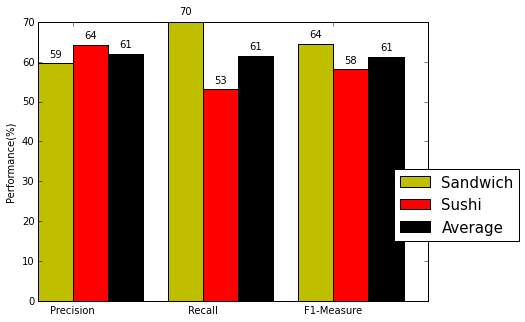

In [15]:
print 'Performance of {} on the Cookpad test dataset \n'.format(MODEL_NAME)

# Calc accuracy, precision, recall and F1-measure of the model
acc, prf_sandwich, prf_sushi, prf_avg = evaluate_model(test_x, test_y, model)

print_results(acc, prf_sandwich, prf_sushi, prf_avg)

# Plot results 
plot_PRF_results(prf_sandwich, prf_sushi, prf_avg, '')

The above table (Also the figure) report three sets of P, R, and F1, one for Sandwich image identification, one for Suchi Image identification, and the third shows the averages of the two. According to these results, identifying Sandwich images seems to give 4.8% lower precision than identifying Suchi images, but 16.9% and 6% higher recall and f1 respectively.

Overall, the average performance of our model is realtively low with 61.5% in Accuracy, 61.9% in P, 61.5% in R, and 61.2% in average F1.

In the next section we describe how to retrain our model from an external image dataset in order to improve its perfomrance

<hr>

## 5 Model Re-Training from External Image Data Source

Now we have our model trained and tested on the Cookpad dataset. However, evaluation results show low performance of the model, which may be a result of the small size of the Cookpad dataset.

Hence, in this section we will continue training our model on images from an external dataset in order to improve it performance.

The dataset we are going to use is the Food-101 dataset (https://www.vision.ee.ethz.ch/datasets_extra/food-101/)
This dataset consist of 101,000 images of 101 food categories (e.g., Apple Pie, Beet Salad, Chiken Wings, etc). Each category consist of 1000 manually labeled images, with 750 and 250 images used for training and testing respectively

Among the 101 food categories in this dataset, I found 4 related to our problem. These are: 
* Club Sandwich, 
* Grilled Cheese Sandwich, 
* Lobster Roll Sandwich, 
* Pulled Pork Sandwich, and Sushi.

Hence, to creat our training data, we merged all the sandwich categroies into one category: "Sandwich" and use it along with the Sushi category to retrain and test our model. The new dataset directoreis and files are defined below.

It's worth noting that the number of images in some food categories is not exactly 1K (750+250). Some categories have lower number images than other categories. 

### 5.1 Load Food_101 Dataset

In [16]:
# Load the 101 food images under the sandwich and sushi categories
SANDWICH_FOOD101_IMG_DIR = 'datasets/food_101_dataset/sandwich'
SUSHI_FOOD101_IMG_DIR = 'datasets/food_101_dataset/sushi'

TRAIN_FOOD101_DATA_FILE = 'datasets/food_101_dataset/training.csv'
TEST_FOOD101_DATA_FILE = 'datasets/food_101_dataset/test.csv'
VALID_FOOD101_DATA_FILE = 'datasets/food_101_dataset/validation.csv'

# Load [path, label] of the Sandwish and Sushi images in the Food101 dataset
sandwich_food101_data = load_data_info(SANDWICH_FOOD101_IMG_DIR)
sushi_food101_data = load_data_info(SUSHI_FOOD101_IMG_DIR)

print 'Size of Food_101 Sandwich Image Set: {}'.format(len(sandwich_food101_data))
print 'Size of Food_101 Sushi Image Set: {}'.format(len(sushi_food101_data))

100%|██████████| 947/947 [00:00<00:00, 6708.61it/s]

Size of Food_101 Sandwich Image Set: 3546
Size of Food_101 Sushi Image Set: 947


Above numbers show that the sandwich categories has 4 to 1 more images than the sushi category. Using such imbalnced dataset to train our model might creat bais problem towards the Sandwich, the dominant class. 
Therefore, we are going to blance the dataset by using the same number of images under both categories as shown below:

In [17]:
# Merge both image sets into one full data
shuffle(sandwich_food101_data)
sandwich_food101_reduced = sandwich_food101_data[:len(sushi_food101_data)]
food101_dataset = sandwich_food101_reduced  + sushi_food101_data

# food101_dataset = sandwich_food101_data + sushi_food101_data
print 'Number images in the Food_101 dataset is: {} with {} Sandwich images and {} Sushi images'.\
format(len(food101_dataset), len(sandwich_food101_reduced), len(sushi_food101_data))

total_food101 = len(food101_dataset)

Number images in the Food_101 dataset is: 1894 with 947 Sandwich images and 947 Sushi images


In [18]:
# Let's now split the data into training, test, and validation subsets
# Stratified sampling is used as usual 
food1010_training, food1010_test, food1010_valid =\
    stratified_split_train_test_valid(food101_dataset, TEST_PROPORTION, VALID_PROPORTION)

# Save the the URL and Label of images in the three subsets 
np.savetxt(fname=TRAIN_FOOD101_DATA_FILE, X=food1010_training, delimiter=' ', fmt='%s')
np.savetxt(fname=TEST_FOOD101_DATA_FILE, X=food1010_test, delimiter=' ', fmt='%s')
np.savetxt(fname=VALID_FOOD101_DATA_FILE, X=food1010_valid, delimiter=' ', fmt='%s')

Now, let's reshape and load images in the training and validation subsets into the memory. 
Here we consider the same image size we used for the Cookpad dataset

Food101 Sandwich_Sushi Dataset:
Number of training images 1212
Number of test images 379
Number of validation images 303
Shape of an image (96, 96, 3)
Shape of label:(2,) ,number of classes: 2


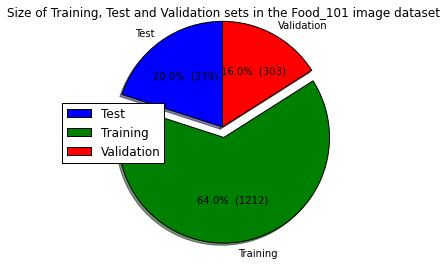

In [19]:
# Load the images and their labels into the memroy
food101_training_x, food101_training_y = image_preloader(TRAIN_FOOD101_DATA_FILE, image_shape=(IMG_SIZE,IMG_SIZE), 
                                        categorical_labels=True,normalize=True)
food101_test_x, food101_test_y = image_preloader(TEST_FOOD101_DATA_FILE, image_shape=(IMG_SIZE,IMG_SIZE), 
                                        categorical_labels=True,normalize=True)
food101_valid_x, food101_valid_y = image_preloader(VALID_FOOD101_DATA_FILE, image_shape=(IMG_SIZE,IMG_SIZE), 
                                        categorical_labels=True,normalize=True)

# Print some stats!
print "Food101 Sandwich_Sushi Dataset:"
print "Number of training images {}".format(len(food101_training_x))
print "Number of test images {}".format(len(food101_test_x))
print "Number of validation images {}".format(len(food101_valid_x))
print "Shape of an image {}" .format(food101_training_x[1].shape)
print "Shape of label:{} ,number of classes: {}".format(food101_training_y[1].shape,len(food101_training_y[1]))

stats_food_101 = {'Training':len(food101_training_x), 'Test':len(food101_test_x), 'Validation':len(food101_valid_x)}
plot_piechart(stats_food_101, "Size of Training, Test and Validation sets in the Food_101 image dataset")

The above figure depicts the number of images in the training, test and validation datasets. According to these numbers: 

* Training set: 1212 Images
* Test set: 379
* Validation set: 303

### 5.2 Model Retraining

Now we have the Food_101 data processed and loaded, the next step is continue training our model from this dataset. To this end, we assume that the previous model (4layers_basic_25epochs) is still in the memory. Thus we will just take it and continue training. 

In case the model is not loaded, we just need to reset the Tensorflow default graph and load the model again as:
<pre>
if os.path.exists(MODEL_NAME):
    model.load(MODEL_NAME)
    print('model loaded!')
</pre>

In [20]:
# Use the Food_101 training and validation data to retrain our model. 
MODEL_NAME = '4layers_extended_25epochs.model'
model.fit({'input': food101_training_x}, {'targets': food101_training_y}, 
          n_epoch=EPOCHS, validation_set=({'input': food101_valid_x}, {'targets': food101_valid_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 699  | total loss: 0.40755 | time: 18.006s
| Adam | epoch: 050 | loss: 0.40755 - acc: 0.8027 -- iter: 1152/1212
Training Step: 700  | total loss: 0.40935 | time: 24.151s
| Adam | epoch: 050 | loss: 0.40935 - acc: 0.8022 | val_loss: 0.40716 - val_acc: 0.8086 -- iter: 1212/1212
--


<img src="figures/retrain_acc_loss_basic.jpg" width='70%'>

As can be noted from the above, continue retraining our model on the Food-101 dataset imroves the validation accuracy substaintially (80.2%) while reducing the loss to 0.4.

Let's now save the model before moving to testing it:

In [21]:
# Save the model 
model.save('./models/4layers_extended_25epochs.model')

INFO:tensorflow:/Users/hs4589/Documents/workspace/cookpad_image_classification/sushi_or_sandwich/models/4layers_extended_25epochs.model is not in all_model_checkpoint_paths. Manually adding it.


INFO:tensorflow:/Users/hs4589/Documents/workspace/cookpad_image_classification/sushi_or_sandwich/models/4layers_extended_25epochs.model is not in all_model_checkpoint_paths. Manually adding it.


### 5.3 Model Evaluation

In this section we are going to evaluate the retrained model on both, the Cookpad and Food_101 test sets separately. We will also test the model on a combined version of both datasets. 

#### 5.3.1 Evaluatation on the Cookpad Test Set

In [22]:
# Evaluate the model on the Cookpad test set
acc_ctest, prf_sandwich_ctest, prf_sushi_ctest, prf_avg_ctest = evaluate_model(test_x, test_y, model)

# print the results
print 'Performance of the retrained model on the Cookpad test dataset'
print_results(acc_ctest, prf_sandwich_ctest, prf_sushi_ctest, prf_avg_ctest)

Performance of the retrained model on the Cookpad test dataset
Accuarcy: 0.553 

Class       Pecision    Recall     F1
--------  ----------  --------  -----
Sandwich       0.553     0.525  0.538
Suchi          0.553     0.580  0.566
Average        0.553     0.553  0.552


As we can notice from the above results, our model perform relatively poorly on the Cookpad testset with 55.3% Accruacy, 55.3% Precision, 55.3% Recall and 55.2% F1 on average. This is probably because the retrained model better adapted to the Food_101 image dataset due to its large size, in comparsion with the small Cookpad dataset, as shown in the figure below.

<img src="figures/datasets.jpg" width='50%'>

To further investigate this issue, we will evaluate the retrained model on the Food_101 test set as follows:

#### 5.3.2 Evaluatation on the Food_101 Test Set

In [23]:
# Evaluate the model on the Food_101 test set
acc_ftest, prf_sandwich_ftest, prf_sushi_ftest, prf_avg_ftest = evaluate_model(food101_test_x, food101_test_y, model)

# print the results
print 'Performance of the retrained model on the Food_101 test dataset'
print_results(acc_ftest, prf_sandwich_ftest, prf_sushi_ftest, prf_avg_ftest)

Performance of the retrained model on the Food_101 test dataset
Accuarcy: 0.821 

Class       Pecision    Recall     F1
--------  ----------  --------  -----
Sandwich       0.828     0.811  0.819
Suchi          0.813     0.831  0.822
Average        0.821     0.821  0.821


As expected, the performance of our model improved substaintially when applied on the Food_101 dataset, with accuracy P, R and F1 of 82.1%.

These results gives an additional indicator that our model performs better when trained from larger datasets than smaller ones. 

Next, we are going to evaluate our model on a combined version of Cookpad and Food_101 test sets.

#### 5.3.3 Evaluatation on the Combined Test Set

In [24]:
# Evaluation on both test sets
COMBINED_TEST_DATA_FILE = "./datasets/combined_test_set"
test_combined = food1010_test + test_data

# Save the the URL and Label of images in the two subsets 
np.savetxt(fname=COMBINED_TEST_DATA_FILE, X=test_combined, delimiter=' ', fmt='%s')
combined_test_x, combined_test_y = image_preloader(COMBINED_TEST_DATA_FILE, image_shape=(IMG_SIZE,IMG_SIZE), 
                                        categorical_labels=True,normalize=True)

predY = model.predict(combined_test_x[:])

acc_com, prf_sandwich_com, prf_sushi_com, prf_avg_com = evaluate_model(combined_test_x, combined_test_y, model)

# print the results
print 'Performance of the retrained model on Combind Cookpad_Food101 test sets'
print_results(acc_com, prf_sandwich_com, prf_sushi_com, prf_avg_com)

Performance of the retrained model on Combind Cookpad_Food101 test sets
Accuarcy: 0.741 

Class       Pecision    Recall     F1
--------  ----------  --------  -----
Sandwich       0.748     0.726  0.737
Suchi          0.734     0.756  0.745
Average        0.741     0.741  0.741


The above results indicate that our model when tested on the combined test set gives a higher performance over the Cookpad test set, but on the other hand, produces a lower performance than the Food_101 test set. 

Overall, the above results represent the performance we would expect from our model in real-world scenarios, where the model is required to identify the classes/categories of images of different properties and data soruces.

<hr>
## 6 Deployment

At this point, we have built and evaluated our model on multiple datasets. Assuming that we are happy with the model performance, the next and last step in this study is to deploy our model as a service that a mobile phone user can use to distinguish between different types of food images taken by the camera of her phone.

Hence in this section we are going to discuss how to take the same model and prepare it for use in a mobile app. Due to time constraints we will leave the actual implementation as future work. 


Deployment as a mobile application requires several modification and optimization processes on the classification model. These processes vary depending on the mobile platform (e.g., Android, iOS, Windows, webOS, etc.). For simplicity, we assume that our task here is to deploy our classifier into an iOS app. Nonetheless, the deployment methodology we will discuss below should be quite the same to other mobile platforms with some tuning and adaptation of course. 

### iOS App Deployment

The proposed classification model is built using Tensorflow. The good news is that Tensorflow provide mobile API's that can be used to build an iOS app that can use our model to make predictions. However, we will need to build Tensorflow from source since Tensorflow for macOS does not include the iOS static library or some of the scripts needed for mobile app development. Assuming that we have XCode installed we can download Tensorflow source and compile using the instruction provided <a href='https://www.tensorflow.org/install/install_sources'>here </a> 

Note that TensorFlow is built using a tool called Bazel (https://bazel.build/), and Bazel requires Java JDK 8. Therefore we should make sure that required packages (i.e., Java, Bazel) are installed before building Tensorflow source. 

Once, we have all required packages and Tensorflow source installed and compiled we can move to developing our iOS app. 

Our main development methodology here consists of the following steps:

##### (1) Extract the Model's Computation Graph 
Reload the classification Model from disk into a Tensorflow session. After that, Extract the computation graph from the session object

##### (2) Freeze Graph 
Unfortunately, Tensorflow does not allow to load the computation graph as-is into the iOS app. This is because the full graph contains operations that are not currently supported by the Tensorflow C++ API. Thus, we need to convert out graph into a <i>Freezed Graph</i>, which is a simplified and optimized version of the full graph. To this end, we need to use the Bazel operation <b>freeze_graph</b> which takes graph.pb and the checkpoint file that contains the trained values for W and b, and merges them into one file. It also removes any operations that are not supported on iOS.

<i>optimize_for_inference</i> is another operation that is typically used to optimize the and seep up the inference (prediction) on IOS. This operation works by simply removing parts of a graph that are only needed for training. This include: Removing training-only operations like checkpoint saving, Stripping out parts of the graph that are never reached, Removing debug operations like CheckNumerics, Folding batch normalization ops into the pre-calculated weights, etc. 

One last thing that most often needs to be done is bypass the Dropout nodes. Leaving the dropout nodes in the graph often leads to exceptions on iOS according to multiple online case studies.

##### (3) Add model to Tensorflow iOS Camera Project

The last step in our deployment pipeline is to create an iOS app that will use our freezed graph to make predictions. An easy and simple tutorial to follow for this purpose is the one provided <a href = 'https://github.com/hollance/TensorFlow-iOS-Example'>here</a>


<b>Resources</b>
* <a href='https://github.com/hollance/TensorFlow-iOS-Example'>TensorFlow-iOS-Example</a>
* <a href='http://machinethink.net/blog/tensorflow-on-ios/'>Getting started with TensorFlow on iOS</a>
* <a href='http://www.mattrajca.com/2016/11/25/getting-started-with-deep-mnist-and-tensorflow-on-ios.html'>Getting Started with Deep MNIST and TensorFlow on iOS</a>
* <a href='https://github.com/stratospark/food-101-mobile'>Creating a Deep Learning iOS App with Keras and Tensorflow</a>
* <a href='https://omid.al/posts/2017-02-20-Tutorial-Build-Your-First-Tensorflow-Android-App.html'>Tutorial: Build Your First Tensorflow Android App
</a>
* <a href='https://petewarden.com/2016/09/27/tensorflow-for-mobile-poets/'>TensorFlow for Mobile Poets</a>
* <a href='https://dato.ml/drop-dropout-from-frozen-model/'>Drop dropout from Tensorflow</a>
* <a href='https://stackoverflow.com/questions/40358892/wipe-out-dropout-operations-from-tensorflow-graph'>Wipe out dropout operations from TensorFlow graph</a>
* <a href='https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/tools/optimize_for_inference.py'>optimize_for_inference.py</a>





<hr>
## 7 Conclusion

In this assignment, we propose a deep learning model for image-based food classification. Our model is built on top of a CNN network that consists of 4 convolutional layers.

The proposed model was initially tested on the Cookpad image set which consists of 804 samples of Sushi and Sandwich images. We showed that our model produces low performance when trained from this dataset solely. 

In the second part of this study we described how to retrain the proposed model from an additional dataset to boost its performance. To this end we used a subset of 1,894 images extracted from the Food_101 dataset. Results showed an increased performance of our model by up to 20% in accuracy and average F1 in comparison with the Cookpad dataset. 

Lastly, in the third part of this study, we provided in-depth discussion on how deep learning models can be deployed as mobile apps using Tensorflow.

<hr>
## References

[1] Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." Advances in neural information processing systems. 2012.

[2] Baldi, Pierre, and Peter J. Sadowski. "Understanding dropout." Advances in Neural Information Processing Systems. 2013.

[3] Lee, Honglak, et al. "Convolutional deep belief networks for scalable unsupervised learning of hierarchical representations." Proceedings of the 26th annual international conference on machine learning. ACM, 2009.